In [1]:
# Only runs with py3.9_pro


In [2]:
import numpy as np
import shapefile
from matplotlib.path import Path
from netCDF4 import Dataset
import matplotlib.pyplot as plt

import pandas as pd
import scipy.stats as sp
import calendar

# % %matplotlib inline

import os
import glob
from tqdm import tqdm
import seaborn as sns
import pickle

import xarray as xr

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [4]:
cDir = os.getcwd()
pltDir = os.path.join(os.path.expanduser(cDir), 'Figs_review_paper') + os.sep

if not os.path.exists(pltDir):
    os.makedirs(pltDir)

In [5]:
import xarray as xr
from glob import glob

def get_st_lt_year_cm5(exp_id = 'historical', len_year = 500):
    
    
    if exp_id in ['historical', 'historicalGHG', 'historicalNat']:
        syear = 1900
        lyear = 2005
    elif (exp_id == 'piControl') & (len_year == 500):
        syear = 1700
        lyear = 2199
    elif (exp_id == 'piControl') & (len_year == 200):
        syear = 1700
        lyear = 1899        
    elif exp_id in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
        syear = 2006
        lyear = 2100
    else:
        print("Not valid exp_id is entered")
        syear = None
        lyear = None
        
    return syear, lyear

def get_st_lt_year_cm6(exp_id = 'historical', len_year = 500):
    
    
    if exp_id in ['hist-GHG', 'hist-aer', 'hist-nat', 'hist-stratO3', 'historical']:
        syear = 1900
        lyear = 2014
    elif (exp_id == 'piControl') & (len_year == 500):
        syear = 1700
        lyear = 2199
    elif (exp_id == 'piControl') & (len_year == 200):
        syear = 1700
        lyear = 1899        
    elif exp_id in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
        syear = 2015
        lyear = 2100
    else:
        print("Not valid exp_id is entered")
        syear = None
        lyear = None
        
    return syear, lyear


def get_st_lt_year_cmip(ctype='CMIP5', exp_id = 'historical', len_year = 500):
    
    if ctype=='CMIP5':
        yr_st, yr_lt = get_st_lt_year_cm5(exp_id = exp_id, len_year = len_year)
        
    if ctype=='CMIP6':
        yr_st, yr_lt = get_st_lt_year_cm6(exp_id = exp_id, len_year = len_year)
        
    return yr_st, yr_lt
    
    
def create_df_from_CMIP_regAvg_netCDF_files(ctype='CMIP5', exp_id='historical', piLength = 500,
                     rDir="../../fracMask_modMDBncFiles"):
    
    st_year, lt_year = get_st_lt_year_cmip(ctype=ctype, exp_id = exp_id, len_year = piLength)
    
    dir_in = os.path.join(rDir, ctype, exp_id)+os.sep
    
    if (ctype == 'CMIP6') & ('hist-' in exp_id):
        scenarioRun = str.split(exp_id, sep="-")[0]+str.upper(str.split(exp_id, sep="-")[-1])
        dir_in = os.path.join(rDir, ctype, scenarioRun)+os.sep

#     print(dir_in)
    
    print(ctype, exp_id)
    
    flist = sorted([*glob(dir_in+"*_{0}_{1}.nc".format(str(st_year), str(lt_year)))], key=lambda s: s.lower())
    model_list = [os.path.split(ff)[-1].split("_")[1] for ff in flist]
    
        # Start generating modellist and filelist for historical runs
    
    
    print(st_year, lt_year)
    
    date_range = pd.date_range(start=str(st_year)+'-01',end = str(lt_year)+'-12', freq ='MS')

    # To store regAVG data from all the models in a single dataframe
    df_regAvg_mthly = pd.DataFrame(data = None, index= date_range, dtype=float)
    
    nf = len(flist)
    
    print("There are {0:3d} no of files in '{1}' scenario".format(nf, exp_id))
    
    for i, ff in enumerate(flist):
        
        model_name = os.path.split(ff)[-1].split("_")[1]
        
        tmp_dat = xr.open_dataset(ff)
        
        vname = list(tmp_dat.keys())[0]
        
        df_regAvg_mthly[model_name] = tmp_dat[vname].values
        
        del model_name, tmp_dat
        
    return df_regAvg_mthly



def create_df_from_OBS_regAvg_netCDF_files(ctype='OBS',
                     rDir="../../fracMask_modMDBncFiles"):
    
    dir_in_obs = os.path.join(rDir, ctype)+os.sep
    
    flist_obs = sorted([*glob(dir_in_obs+"*.nc")], key=lambda s: s.lower())
    
    for i, ff in enumerate(flist_obs):
        tmp_obs = xr.open_dataset(ff)
        vname = list(tmp_obs.keys())[0]
        
#         print(vname)
#         syr = tmp_obs.time.dt.year.values[0]
#         lyr = tmp_obs.time.dt.year.values[-1]
#         smo = tmp_obs.time.dt.month.values[0]
#         lmo = tmp_obs.time.dt.month.values[-1]
        
        st_time = tmp_obs.time.values[0].astype(str)[0:7]
        lt_time = tmp_obs.time.values[-1].astype(str)[0:7]
        

        date_range = pd.date_range(start=st_time, end = lt_time, freq ='MS')
        obs_name = os.path.split(ff)[-1].split("_")[1]
        
        print(obs_name, st_time, lt_time)
        
        df_regAvg_mthly = pd.DataFrame(data = None, index= date_range, dtype=float)
        
        df_regAvg_mthly[obs_name] = tmp_obs[vname].values
        
        if i == 0:
            df_out = df_regAvg_mthly
        else:
            df_out = pd.concat([df_out, df_regAvg_mthly], axis=1)
            
        del df_regAvg_mthly, date_range, obs_name, st_time, lt_time
       
    return df_out
        

In [6]:
rDir_cmp="../../fracMask_modMDBncFiles/"

In [7]:
df_obs_all = create_df_from_OBS_regAvg_netCDF_files(ctype='OBS', rDir = rDir_cmp)

AGCD-V1-masked 1900-01 2019-12
AGCD-V1 1900-01 2019-12
AGCD-V2-masked 1900-01 2021-12
AGCD-V2 1900-01 2021-12
CRU-TSv405 1901-01 2020-12
SILO 1889-01 2021-12


In [8]:
awapMB = df_obs_all[['AGCD-V2-masked']].dropna().copy()


In [9]:
# awapMB = awapMB.rename({'AGCD-V2': 'awap'})

awapMB.columns= ['awap']

In [10]:
awapMB

,awap
1900-01-01,44.426015
1900-02-01,19.311703
1900-03-01,58.051605
1900-04-01,32.950381
1900-05-01,49.296883
...,...
2021-08-01,19.584619
2021-09-01,35.510429
2021-10-01,34.891337
2021-11-01,130.483524


In [11]:
histMB = create_df_from_CMIP_regAvg_netCDF_files(ctype='CMIP6', exp_id='historical', piLength = 500, rDir = rDir_cmp)

pi5MB = create_df_from_CMIP_regAvg_netCDF_files(ctype='CMIP6', exp_id='piControl', piLength = 500, rDir = rDir_cmp)
pi2MB = create_df_from_CMIP_regAvg_netCDF_files(ctype='CMIP6', exp_id='piControl', piLength = 200, rDir = rDir_cmp)

CMIP6 historical
1900 2014
There are  52 no of files in 'historical' scenario
CMIP6 piControl
1700 2199
There are  38 no of files in 'piControl' scenario
CMIP6 piControl
1700 1899
There are  47 no of files in 'piControl' scenario


In [12]:
ssp585MB = create_df_from_CMIP_regAvg_netCDF_files(ctype='CMIP6', exp_id='ssp585', piLength = 500, rDir = rDir_cmp)
ssp370MB = create_df_from_CMIP_regAvg_netCDF_files(ctype='CMIP6', exp_id='ssp370', piLength = 500, rDir = rDir_cmp)
ssp245MB = create_df_from_CMIP_regAvg_netCDF_files(ctype='CMIP6', exp_id='ssp245', piLength = 500, rDir = rDir_cmp)
ssp126MB = create_df_from_CMIP_regAvg_netCDF_files(ctype='CMIP6', exp_id='ssp126', piLength = 500, rDir = rDir_cmp)

CMIP6 ssp585
2015 2100
There are  33 no of files in 'ssp585' scenario
CMIP6 ssp370
2015 2100
There are  28 no of files in 'ssp370' scenario
CMIP6 ssp245
2015 2100
There are  31 no of files in 'ssp245' scenario
CMIP6 ssp126
2015 2100
There are  31 no of files in 'ssp126' scenario


In [13]:
# Find the avaliable models in each scenario (Any one of the region data can be used as they all have similar no of models)

mod_hist = histMB.columns

mod_ssp585 = ssp585MB.columns
mod_ssp370 = ssp370MB.columns
mod_ssp245 = ssp245MB.columns
mod_ssp126 = ssp126MB.columns

mod_pi5 = pi5MB.columns
mod_pi2 = pi2MB.columns

mod_len = [len(mod_hist), len(mod_ssp585), len(mod_ssp370), len(mod_ssp245), len(mod_ssp126), len(mod_pi5), len(mod_pi2)]

In [14]:
mod_len_str = [str(i) for i in mod_len]
print("Length of models in Hist; SSP585; SSP370; SSP245; SSP126; piCTL500 and piCTL200 are as below \n *********")
print(mod_len_str)

Length of models in Hist; SSP585; SSP370; SSP245; SSP126; piCTL500 and piCTL200 are as below 
 *********
['52', '33', '28', '31', '31', '38', '47']


In [15]:
# Comnbined all the models and find the number of models unique under CMIP5 runs
model_uq = np.unique(list(mod_hist)+list(mod_ssp585)+list(mod_ssp370)+list(mod_ssp245)+list(mod_ssp126)+list(mod_pi2))

sorted_model_uq = sorted(np.unique(model_uq), key=lambda s: s.lower())

In [16]:
model_all = {'piControl200':mod_pi2, 'piControl500':mod_pi5, 
             'Historical-All': mod_hist,  
             'SSP5.85':mod_ssp585, 'SSP3.70':mod_ssp370, 'SSP2.45':mod_ssp245, 'SSP1.26':mod_ssp126}

In [17]:
cmp6_models = pd.DataFrame(index=sorted_model_uq, columns=list(model_all.keys()))

for rtype in list(model_all.keys()):
    
    mod_tmp = model_all[rtype]
#     print(mod_tmp)
    
    cmp6_models.loc[mod_tmp, rtype] = 1

In [18]:
cmp6_models

,piControl200,piControl500,Historical-All,SSP5.85,SSP3.70,SSP2.45,SSP1.26
ACCESS-CM2,1,1,1,1,1,1,1
ACCESS-ESM1-5,1,1,1,1,1,1,1
AWI-CM-1-1-MR,1,1,1,1,1,1,1
AWI-ESM-1-1-LR,NaN,NaN,1,NaN,NaN,NaN,NaN
BCC-CSM2-MR,1,1,1,1,1,1,1
BCC-ESM1,1,NaN,1,NaN,NaN,NaN,NaN
CAMS-CSM1-0,1,1,1,NaN,NaN,NaN,NaN
CanESM5,1,1,1,1,1,1,1
CAS-ESM2-0,1,1,1,1,1,1,1
CESM2,1,1,1,1,NaN,NaN,1


In [19]:
cmp6_models[['Historical-All' ,'SSP3.70']].dropna().sum()

Historical-All    28
SSP3.70           28
dtype: object

In [20]:
cmp6_models[(cmp6_models['SSP3.70'].isna()) & (cmp6_models['SSP5.85']==1)]#['piControl200'].dropna()

,piControl200,piControl500,Historical-All,SSP5.85,SSP3.70,SSP2.45,SSP1.26
CESM2,1,1,1,1,NaN,NaN,1
CIESM,1,1,1,1,NaN,1,1
E3SM-1-1,NaN,NaN,1,1,NaN,NaN,NaN
EC-Earth3-CC,1,1,1,1,NaN,1,NaN
FIO-ESM-2-0,NaN,NaN,1,1,NaN,1,1
GFDL-CM4,1,1,1,1,NaN,1,NaN
NESM3,1,NaN,1,1,NaN,1,1


In [21]:
cmp6_models[(cmp6_models['SSP2.45'].isna()) & (cmp6_models['SSP5.85']==1)]#['piControl200'].dropna()

,piControl200,piControl500,Historical-All,SSP5.85,SSP3.70,SSP2.45,SSP1.26
CESM2,1,1,1,1,NaN,NaN,1
E3SM-1-1,NaN,NaN,1,1,NaN,NaN,NaN


In [22]:
cmp6_models[(cmp6_models['SSP1.26'].isna()) & (cmp6_models['SSP5.85']==1)]#['piControl200'].dropna()

,piControl200,piControl500,Historical-All,SSP5.85,SSP3.70,SSP2.45,SSP1.26
E3SM-1-1,NaN,NaN,1,1,NaN,NaN,NaN
EC-Earth3-CC,1,1,1,1,NaN,1,NaN
GFDL-CM4,1,1,1,1,NaN,1,NaN


In [23]:
cmp6_models[['piControl200', 'Historical-All' ,'SSP2.45']].dropna().sum()

piControl200      30
Historical-All    30
SSP2.45           30
dtype: object

In [24]:
cmp6_models[['piControl200', 'Historical-All' ,'SSP1.26']].dropna().sum()

piControl200      30
Historical-All    30
SSP1.26           30
dtype: object

In [25]:
cmp6_models[['piControl200', 'Historical-All', 'SSP5.85' ]].dropna().sum()

piControl200      31
Historical-All    31
SSP5.85           31
dtype: object

In [26]:
cmp6_models[['piControl200', 'Historical-All' ,'SSP3.70']].dropna().sum()

piControl200      28
Historical-All    28
SSP3.70           28
dtype: object

In [27]:
def get_common_modellist(mhist, mrcp):
    cmodels = [model for model in mhist if model in mrcp]
    return cmodels

In [28]:
# GET THE COMMON MODEL LIST that exist in hist and SSP runs 

# Models that are common between Hist and different future runs
hist_ssp585_cmod = get_common_modellist(mod_hist, mod_ssp585)
hist_ssp370_cmod = get_common_modellist(mod_hist, mod_ssp370)
hist_ssp245_cmod = get_common_modellist(mod_hist, mod_ssp245)
hist_ssp126_cmod = get_common_modellist(mod_hist, mod_ssp126)

# Models that are common between Hist and different piCTL runs
hist_pi5_cmod = get_common_modellist(mod_hist, mod_pi5)
hist_pi2_cmod = get_common_modellist(mod_hist, mod_pi2)

# Models that are common between Hist, ssp5.85 and different piCTL runs
pi5_hist_ssp585_cmod = get_common_modellist(hist_ssp585_cmod, mod_pi5)
pi2_hist_ssp585_cmod = get_common_modellist(hist_ssp585_cmod, mod_pi2)

# Models that are common between Hist, ssp3.70 and different piCTL runs
pi5_hist_ssp370_cmod = get_common_modellist(hist_ssp370_cmod, mod_pi5)
pi2_hist_ssp370_cmod = get_common_modellist(hist_ssp370_cmod, mod_pi2)

# Models that are common between Hist, ssp2.45 and different piCTL runs
pi5_hist_ssp245_cmod = get_common_modellist(hist_ssp245_cmod, mod_pi5)
pi2_hist_ssp245_cmod = get_common_modellist(hist_ssp245_cmod, mod_pi2)

# Models that are common between Hist, ssp1.26 and different piCTL runs
pi5_hist_ssp126_cmod = get_common_modellist(hist_ssp126_cmod, mod_pi5)
pi2_hist_ssp126_cmod = get_common_modellist(hist_ssp126_cmod, mod_pi2)

In [29]:
print([len(hist_ssp585_cmod), len(hist_ssp370_cmod), len(hist_ssp245_cmod), len(hist_ssp126_cmod)])

[33, 28, 31, 31]


In [30]:
mod_pi2

Index(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'BCC-ESM1', 'CAMS-CSM1-0', 'CanESM5', 'CAS-ESM2-0', 'CESM2-FV2',
       'CESM2-WACCM-FV2', 'CESM2-WACCM', 'CESM2', 'CIESM', 'CMCC-CM2-SR5',
       'CMCC-ESM2', 'E3SM-1-0', 'EC-Earth3-AerChem', 'EC-Earth3-CC',
       'EC-Earth3-Veg-LR', 'EC-Earth3-Veg', 'EC-Earth3', 'FGOALS-f3-L',
       'FGOALS-g3', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-H',
       'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IITM-ESM', 'INM-CM4-8',
       'INM-CM5-0', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6',
       'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0',
       'NESM3', 'NorCPM1', 'NorESM1-F', 'NorESM2-LM', 'NorESM2-MM',
       'SAM0-UNICON', 'TaiESM1'],
      dtype='object')

In [31]:
print(len(pi2_hist_ssp585_cmod), len(pi2_hist_ssp370_cmod), len(pi2_hist_ssp245_cmod), len(pi2_hist_ssp126_cmod))

31 28 30 30


In [32]:
## Get the common models between the piControl, historical, ssp585, and ssp370
cmod_pi2_hist_585_370 = get_common_modellist(pi2_hist_ssp585_cmod, pi2_hist_ssp370_cmod)
print(len(cmod_pi2_hist_585_370))

## Get the common models between the piControl, historical, ssp245, and ssp126
cmod_pi2_hist_245_126 = get_common_modellist(pi2_hist_ssp245_cmod, pi2_hist_ssp126_cmod)
print(len(cmod_pi2_hist_245_126))

26
28


In [33]:
## Get the common models between the piControl, historical, ssp585, ssp370, ssp245, and ssp126
cmod_all = get_common_modellist(cmod_pi2_hist_585_370, cmod_pi2_hist_245_126)
print(len(cmod_all))

26


In [34]:
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if isinstance(X, pd.Series):
        X = X.copy()
        X.index = range(len(X.index))
    elif isinstance(X, pd.DataFrame):
        X=pd.Series(X.values.flatten())
        
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = np.array(X[resample_i])  # TODO: write a test demonstrating why array() is important
    return X_resample

In [35]:
def bootstrap_regAvg_data(df_data, nrepeat = 1000, yrExtract=[1900, 1959, 2017, 2019], stat='mean'):
    '''
    
    '''
    np.random.seed(0)
    pi_boot_diff = pd.DataFrame(index=np.arange(0, nrepeat))
    pi_boot_perc = pd.DataFrame(index=np.arange(0, nrepeat))
    pi_boot_norm = pd.DataFrame(index=np.arange(0, nrepeat))


    for model in df_data.columns:

        X1_pi = df_data[[model]]

        ## Bootstrapping the whole time series

        stat_diff = np.zeros(nrepeat, dtype=float)
        stat_diff_perc = stat_diff.copy()
        stat_diff_norm = stat_diff.copy()

        for i in range(nrepeat):

            # Resample the whole 
            if i == 0:
                X_resample_all = X1_pi.copy()
            else:                
                X_resample_all = bootstrap_resample(X1_pi)

            # Convert to pandas dataframe to subset abd do all the calculations
            X_resample = pd.DataFrame(X_resample_all, index=X1_pi.index)
            
            # Extract the data for climatological period
            clim_tmp = X_resample[(X_resample.index.year >= yrExtract[0]) & (X_resample.index.year <= yrExtract[1])]
            
            ref_tmp = X_resample[(X_resample.index.year >= yrExtract[2]) & (X_resample.index.year <= yrExtract[-1])]
            
            
            # Compute the STD of reference years
            X_std = clim_tmp.std().values  
            
            if stat == 'mean':
                X_mu = clim_tmp.mean().values  
                X_bar = ref_tmp.mean().values  
            elif stat == 'median':
                X_mu = clim_tmp.median().values  
                X_bar = ref_tmp.median().values 
            else:
                raise Exception ("Stat given is invalid")

            stat_diff[i] = X_bar - X_mu
            stat_diff_perc[i] = 100 * stat_diff[i]/X_mu
            stat_diff_norm[i] = stat_diff[i]/X_std

            del X_resample_all, X_resample, X_mu, X_std, X_bar, clim_tmp, ref_tmp  

        pi_boot_diff[model]  = stat_diff.flatten()
        pi_boot_perc[model]  = stat_diff_perc.flatten()
        pi_boot_norm[model]  = stat_diff_norm.flatten()

        del stat_diff, stat_diff_perc, stat_diff_norm
        
    return pi_boot_diff, pi_boot_perc, pi_boot_norm  


In [36]:
# Extract the season and compute the seasonal average to do all the calculation
smon = 4
lmon = 9

In [37]:

awapMB_cl =  awapMB[(awapMB.index.month>=smon) & (awapMB.index.month<=lmon)].resample('A').mean()

# Compute the inter-decadal stats
runMeanWindow = 10
awapMB_cl_10y = awapMB_cl.rolling(runMeanWindow,  center=True).mean()

awapMB_sigma_10 = awapMB_cl_10y[awapMB_cl_10y.index.year <= 1959].std()

awapMB_all_sigma_10 = awapMB_cl_10y.std()

In [38]:
print(awapMB_sigma_10)

awap    2.783922
dtype: float64


In [39]:
# # DO t-Test to evaluate the statistical significance of the OBSERVED CHANGE

# from scipy import stats

In [40]:
# Refernce period mean
ref_avg = awapMB_cl[(awapMB_cl.index.year >= 1900) & (awapMB_cl.index.year <= 1959)]['awap'].values

# TBD (2017-2019) mean
tar_avg = awapMB_cl[(awapMB_cl.index.year >= 2017) & (awapMB_cl.index.year <= 2019)]['awap'].values


In [41]:
# Find the observed change in rainfall over all the three regions

delR_MB = tar_avg.mean() - ref_avg.mean()
perR_MB = 100 * (tar_avg.mean() - ref_avg.mean())/ref_avg.mean()
stdR_MB = (tar_avg.mean() - ref_avg.mean())/ref_avg.std()


In [42]:
print(delR_MB, perR_MB, stdR_MB)

-17.268220900941827 -54.66578647691411 -1.8057585850558164


In [43]:
# Change in terms of inter-decadal standard deviations
print(delR_MB/awapMB_sigma_10)                


awap   -6.20284
dtype: float64


In [44]:
# Change in terms of inter-decadal standard deviations using full record
print(delR_MB/awapMB_all_sigma_10)

awap   -5.584927
dtype: float64


In [45]:
# Estimate the probable range of change using Bootstrapping
awapMB_btDiff, awapMB_btPerc, awapMB_btNorm = bootstrap_regAvg_data(awapMB_cl, nrepeat = 10000, 
                                                                    yrExtract=[1901, 1960, 2017, 2019])

In [46]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

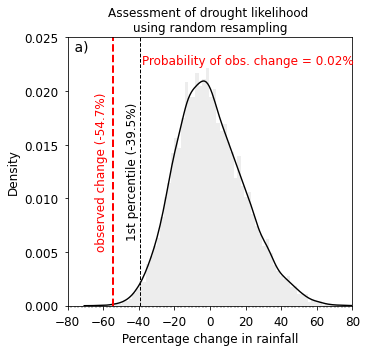

In [47]:
stat_type = 'perc'

boot_data = awapMB_btPerc.copy()
obs_diff = perR_MB.copy()

xlimits = [-80, 80]
ylimits = [0, 0.025]

# sname = 'Cool (Apr-Sep) season'
sname = "Assessment of drought likelihood \nusing random resampling"
with plt.style.context('seaborn-paper'):
    f, ax = plt.subplots(1, figsize=(5.20, 5))

    # Get the column name
    reg = boot_data.columns

    # Compute the percentiles values
    xtemp_perc= boot_data[reg].describe(percentiles=[0.01,0.05,0.5])

    perc_1 = xtemp_perc.loc["1%"].values[0]
    perc_5 = xtemp_perc.loc["5%"].values[0]
#     perc_1 = xtemp_perc.loc["1%"].values[0]
    
    sns.distplot(boot_data[reg], bins=75, ax=ax, kde_kws={"color": "k"}, hist_kws={"color": "lightgray"})
#     ax.axvline(linewidth=1, color='k', linestyle='-.')
    ax.axvline(obs_diff, linewidth=2, color='r', linestyle='--')#, linestyle='-.')
    ax.axvline(perc_1, linestyle='--', color='k',linewidth=1)
#     ax.axvline(perc_5, linestyle='--', color='k',linewidth=1)

#         ax.text(0.015, 0.925, '{0} '.format(sname), fontsize=12, transform=ax.transAxes)

    probX = 100*boot_data[boot_data <= obs_diff].count().values[0]/len(boot_data.values)

#     ax.text(0.55, 0.90, "Pr[X <= OBS] = {0:.2f}%".format(probX), fontsize=10, color= 'r',transform=ax.transAxes)
    
    ax.text(obs_diff-10, 0.0125, "observed change ({0:.1f}%)".format(obs_diff), fontsize=12, color= 'r', 
            rotation=90, va='center')
    ax.text(xtemp_perc.loc["1%"].values[0]-7.5, 0.0125, "1st percentile ({0:.1f}%)".format(perc_1), fontsize=12, color= 'k', 
            rotation=90, va='center')
    

    ax.text(0.26, 0.90, "Probability of obs. change = {0:.2f}%".format(probX), fontsize=12, color= 'r',
            transform=ax.transAxes)
    
#     ax.text(obs_diff-10, 0.0125, "observed change", fontsize=12, color= 'r', 
#             rotation=90, va='center')
#     ax.text(xtemp_perc.loc["1%"].values[0]-7.5, 0.0125, "1st percentile", fontsize=12, color= 'k', 
#             rotation=90, va='center')
    
    ax.set_xlim(xlimits[0], xlimits[-1])
    ax.set_ylim(ylimits[0], ylimits[-1])

    ax.text(0.010, 0.95, " a)", fontsize=14, color= 'k',
            transform=ax.transAxes)

    # Define the xlabel according to stat type
    if stat_type == 'anom':
#             xlab_text = r'$\Delta {R}$'+r' in (mm month $^{-1})$ '
#             xlab_text = r'$(\bar {X}_{2017-2019} - \mu_{1900-1959})$ (mm month$^{-1})$'
        xlab_text = r' Change in rainfall (mm month$^{-1})$'
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(2))

    if stat_type == 'perc':
#             xlab_text =r'$\Delta {R} $ (in %) '
#             xlab_text ='100*('+r'$\bar {X}_{2017-2019} - \mu_{1900-1959})/ \mu_{1900-1959}$'
        xlab_text = r' Percentage change in rainfall '
        ax.xaxis.set_major_locator(plt.MultipleLocator(20))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(2))

    if stat_type == 'norm':
#             xlab_text = r'$\Delta R/\sigma $ '
#             xlab_text = r'$\bar {X}_{2017-2019} - \mu_{1900-1959})/ \sigma_{1900-1959}$'
        xlab_text = r' Normalized change in rainfall '
        ax.xaxis.set_major_locator(plt.MultipleLocator(1))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))

#         ax.text(0.65, 0.90, "{0} ".format(reg), fontsize=12, transform=ax.transAxes)
    ax.set_xlabel(xlab_text, fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)

    ax.set_title(sname, fontsize=12)

    plt.tight_layout()

#     if savePlot:
#         if pngOut is None:
#             pltDir = os.getcwd()
#             pngOut = os.path.join(pltDir, '{0}_boot_pdf_test.png'.format(stat_type))          

#         plt.savefig(pngOut, dpi=300, bbox_inches='tight', orientation='portrait')

#     pdfOut = os.path.join(pltDir, 'Fig04a_bootstrap_likelihood_Tinderbox_Drought.pdf')          

#     plt.savefig(pdfOut, dpi=300, bbox_inches='tight', orientation='portrait')
    
    plt.show()
    plt.close()

In [48]:

print("Probability of rainfall change equal to or less than the observed TBD change")

print("**********")
prob_perR_MB = 100*sum(awapMB_btPerc.values.flatten() <= perR_MB)/len(awapMB_btPerc.values.flatten())
print("Using perR = {0:.3f}%".format(prob_perR_MB))

print("**********************")


Probability of rainfall change equal to or less than the observed TBD change
**********
Using perR = 0.020%
**********************


In [49]:
obs_tmp = awapMB_cl.copy()

In [50]:
obs_tmp.index.year[0], obs_tmp.index.year[-1]

(1900, 2021)

In [51]:
# Another way to do a bootstrapping using all the 3-year anomalies from 2001 onwards (Suggested by Reviewer-2)

In [52]:
# obs_tmp = awapMB_cl.copy()

obs_tmp_clim = obs_tmp[(obs_tmp.index.year >= 1900) & (obs_tmp.index.year <= 1959)].mean()

In [53]:
nyr_rol = 3
obs_tmp_nyr = obs_tmp.rolling(nyr_rol, center= True ).mean()

obs_tmp_nyr_anom = obs_tmp_nyr - obs_tmp_clim

obs_tmp_nyr_perc = 100 * obs_tmp_nyr_anom / obs_tmp_clim

In [54]:
obs_tmp_nyr_perc[obs_tmp.index.year >= 2001].dropna().shape

(20, 1)

In [55]:
obs_tmp_nyr_perc[obs_tmp.index.year >= 2001]

,awap
2001-12-31,-24.662051
2002-12-31,-26.494706
2003-12-31,-27.339301
2004-12-31,-6.167909
2005-12-31,-14.917671
2006-12-31,-13.115789
2007-12-31,-22.827411
2008-12-31,-16.045421
2009-12-31,0.361039
2010-12-31,1.513513


In [56]:
pd.date_range('2001', '2020', freq='ys')

DatetimeIndex(['2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
               '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [57]:
def bt_regAvg_obs_ch_centered(df_obs, nrepeat = 1000, clim_yrs = [1900, 1959], 
                              cen_yrs = [2001, 2020], nyr_rol = 3):
    '''
    In this method, the full historical records is resampled 'nrepeat times' and each time
    % change in nyr-year rainfall mean relative to the 'clim_yrs' mean is computed 
    Only values that are within 'cen_yrs' range is selected to estimate the likelihood.
    '''
    
    np.random.seed(0)
    
    date_cen = pd.date_range(str(cen_yrs[0]), str(cen_yrs[-1]), freq='ys')
    

    bt_diff = pd.DataFrame(index = date_cen, columns = np.arange(0, nrepeat), dtype='float')
    bt_perc = pd.DataFrame(index = date_cen, columns = np.arange(0, nrepeat), dtype='float')
    bt_norm = pd.DataFrame(index = date_cen, columns = np.arange(0, nrepeat), dtype='float')

    bt_diff_min = pd.DataFrame(index = np.arange(0, nrepeat), columns =['min'], dtype='float')
    bt_perc_min = pd.DataFrame(index = np.arange(0, nrepeat), columns =['min'], dtype='float')
    bt_norm_min = pd.DataFrame(index = np.arange(0, nrepeat), columns =['min'], dtype='float')
    
    df_tmp = df_obs.copy()

    ## Bootstrapping the whole time series

    for i in range(nrepeat):

        # Resample the whole 
        if i == 0:
            X_resample_all = df_tmp.copy()
        else:                
            X_resample_all = bootstrap_resample(df_tmp)
            

        # Convert to pandas dataframe to subset abd do all the calculations
        X_resample = pd.DataFrame(X_resample_all, index = df_tmp.index)

        # Extract the data for climatological period
        clim_tmp = X_resample[(X_resample.index.year >= clim_yrs[0]) & (X_resample.index.year <= clim_yrs[1])]
        
        # Compute the mean and std
        clim_tmp_avg = clim_tmp.mean()
        
#         print(i, obs_tmp_clim_avg)
        
        clim_tmp_std = clim_tmp.std()
        
        # Compute the rolling average
        obs_tmp_nyr = X_resample.rolling(nyr_rol, center = True).mean()

        # Compute the change relative to climatology
        obs_tmp_nyr_diff = obs_tmp_nyr - clim_tmp_avg

        obs_tmp_nyr_perc = 100 * obs_tmp_nyr_diff / clim_tmp_avg
        
        obs_tmp_nyr_norm = obs_tmp_nyr_diff / clim_tmp_std


        bt_diff.loc[:, i] = obs_tmp_nyr_diff[(obs_tmp_nyr_diff.index.year >= cen_yrs[0]) & \
                                             (obs_tmp_nyr_diff.index.year <= cen_yrs[1])].values
        
        bt_perc.loc[:, i] = obs_tmp_nyr_perc[(obs_tmp_nyr_perc.index.year >= cen_yrs[0]) & \
                                             (obs_tmp_nyr_perc.index.year <= cen_yrs[1])].values
        
        bt_norm.loc[:, i] = obs_tmp_nyr_norm[(obs_tmp_nyr_norm.index.year >= cen_yrs[0]) & \
                                             (obs_tmp_nyr_norm.index.year <= cen_yrs[1])].values
        
        bt_diff_min.loc[i] = obs_tmp_nyr_diff.min().values
        bt_perc_min.loc[i] = obs_tmp_nyr_perc.min().values
        bt_norm_min.loc[i] = obs_tmp_nyr_norm.min().values
        
        
        del X_resample, clim_tmp, clim_tmp_avg, clim_tmp_std, obs_tmp_nyr
        del obs_tmp_nyr_diff, obs_tmp_nyr_perc, obs_tmp_nyr_norm
        
        # Use full period minimum values
        dic_full_min = {'full_min_diff':bt_diff_min, 'full_min_perc':bt_perc_min, 'full_min_norm':bt_norm_min}
        
        # Use recent period chamges
        dic_rec_chg = {'bt_diff':bt_diff, 'bt_perc':bt_perc, 'bt_norm':bt_norm}

#     return bt_diff, bt_perc, bt_norm  
    return dic_full_min, dic_rec_chg

In [59]:
dic_full_min, dic_rec_chg = bt_regAvg_obs_ch_centered(obs_tmp, nrepeat = 10000, clim_yrs = [1900, 1959], 
                                              cen_yrs = [2001, 2020], nyr_rol = 3)

In [60]:
tmp_bt_diff = dic_rec_chg['bt_diff']
tmp_bt_perc = dic_rec_chg['bt_perc']
tmp_bt_norm = dic_rec_chg['bt_norm']

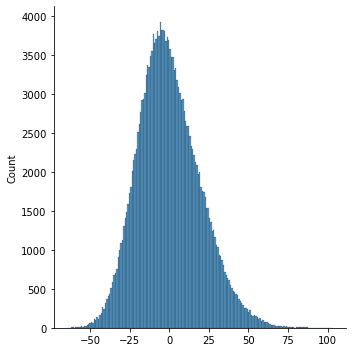

In [61]:
sns.displot(tmp_bt_perc.values.flatten())

In [62]:
perR_MB

-54.66578647691411

In [63]:
tmp_bt_perc2 = tmp_bt_perc[tmp_bt_perc <= perR_MB]

In [64]:
tmp_bt_perc2.count().sum()

77

In [65]:
# tmp_bt_perc2.dropna(how='all', axis=1)

In [66]:
# tmp_bt_perc3 = tmp_bt_perc2.dropna(how='all', axis=1)

In [67]:
# tmp_bt_perc3_cnt = tmp_bt_perc3.count()

In [68]:
# tmp_bt_perc3_cnt

In [69]:
# tmp_bt_perc3_cnt[tmp_bt_perc3_cnt > 1]

In [70]:
# sum(tmp_bt_perc.values.flatten() <= perR_MB)

In [71]:
print("Probability of rainfall change equal\nto or less than the observed change for any 3-consecutive years between 2001-2020")
print("**********************")

new_prob_perR_MB = 100*sum(tmp_bt_perc.values.flatten() <= perR_MB)/len(tmp_bt_perc.values.flatten())
print("Using perR = {0:.3f}%".format(new_prob_perR_MB))
print("**********************")


Probability of rainfall change equal
to or less than the observed change for any 3-consecutive years between 2001-2020
**********************
Using perR = 0.038%
**********************


In [72]:
tmp_bt_perc_min = tmp_bt_perc.min()

In [73]:
100*len(tmp_bt_perc_min[tmp_bt_perc_min <= perR_MB])/10000

0.72

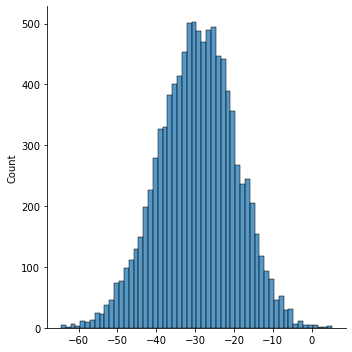

In [74]:
sns.displot(tmp_bt_perc_min.values.flatten())

In [75]:
min_bt_diff = dic_full_min['full_min_diff']
min_bt_perc = dic_full_min['full_min_perc']
min_bt_norm = dic_full_min['full_min_norm']

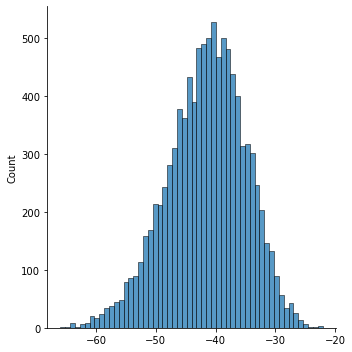

In [76]:
sns.displot(min_bt_perc.values.flatten())

In [77]:
print("Probability of rainfall change equal\nto or less than the observed change for the driest 3-consecutive years in historical records")
print("**********************")
dry_prob_perR_MB = 100*sum(min_bt_perc.values.flatten() <= perR_MB)/len(min_bt_perc.values.flatten())
print("Using perR = {0:.3f}%".format(dry_prob_perR_MB))
print("**********************")

Probability of rainfall change equal
to or less than the observed change for the driest 3-consecutive years in historical records
**********************
Using perR = 3.240%
**********************


# USE CMIP6 MODELS

In [78]:
pi2MB_cl = pi2MB[(pi2MB.index.month >=smon) & (pi2MB.index.month <=lmon)].resample('A').mean()
histMB_cl = histMB[(histMB.index.month >=smon) & (histMB.index.month <=lmon)].resample('A').mean()
ssp585MB_cl = ssp585MB[(ssp585MB.index.month >=smon) & (ssp585MB.index.month <=lmon)].resample('A').mean()
ssp370MB_cl = ssp370MB[(ssp370MB.index.month >=smon) & (ssp370MB.index.month <=lmon)].resample('A').mean()
ssp245MB_cl = ssp245MB[(ssp245MB.index.month >=smon) & (ssp245MB.index.month <=lmon)].resample('A').mean()
ssp126MB_cl = ssp126MB[(ssp126MB.index.month >=smon) & (ssp126MB.index.month <=lmon)].resample('A').mean()

In [79]:
print(len(hist_ssp585_cmod), len(hist_ssp370_cmod), len(hist_ssp245_cmod), len(hist_ssp126_cmod))

33 28 31 31


In [80]:
# COMBINE HIST AND FUTURE SCENARIO
dfMB_hist_ssp585_cl = pd.concat((histMB_cl[hist_ssp585_cmod], ssp585MB_cl[hist_ssp585_cmod]), axis=0)
dfMB_hist_ssp370_cl = pd.concat((histMB_cl[hist_ssp370_cmod], ssp370MB_cl[hist_ssp370_cmod]), axis=0)
dfMB_hist_ssp245_cl = pd.concat((histMB_cl[hist_ssp245_cmod], ssp245MB_cl[hist_ssp245_cmod]), axis=0)
dfMB_hist_ssp126_cl = pd.concat((histMB_cl[hist_ssp126_cmod], ssp126MB_cl[hist_ssp126_cmod]), axis=0)

# If you want to use common model then comment the above and use this, otherwise use above
# dfMB_hist_ssp585_cl = pd.concat((histMB_cl[cmod_all], ssp585MB_cl[cmod_all]), axis=0)
# dfMB_hist_ssp370_cl = pd.concat((histMB_cl[cmod_all], ssp370MB_cl[cmod_all]), axis=0)
# dfMB_hist_ssp245_cl = pd.concat((histMB_cl[cmod_all], ssp245MB_cl[cmod_all]), axis=0)
# dfMB_hist_ssp126_cl = pd.concat((histMB_cl[cmod_all], ssp126MB_cl[cmod_all]), axis=0)

In [81]:
# Reindex the piCTL data to do a boot-strapping using the year index
pi2MB_cl_adj = pi2MB_cl[pi2_hist_ssp585_cmod].copy()
pi2MB_cl_adj.index = pd.period_range(end='2019', periods=len(pi2MB_cl_adj), freq='Y')

In [82]:
pi2MB_cl_adj.shape

(200, 31)

In [84]:
# pi2MB_cl_adj

In [85]:
# Perform the boot-strapping to estimate the change in rainfall due to internal variability
piMB_btDiff, piMB_btPerc, piMB_btNorm = bootstrap_regAvg_data(pi2MB_cl_adj, nrepeat = 1000, 
                                                                yrExtract=[1901, 1960, 2017, 2019])
# piMB_btDiff, piMB_btPerc, piMB_btNorm = bootstrap_regAvg_data_pi(pi2MB_cl, nrepeat = 1000, yrExtract=[120, 60, 117])

In [86]:
piMB_btDiff.shape

(1000, 31)

In [87]:
# Vectorize to plot the distribution
piMB_btDiff_ar = piMB_btDiff.values.flatten()
piMB_btPerc_ar = piMB_btPerc.values.flatten()
piMB_btNorm_ar = piMB_btNorm.values.flatten()

In [88]:
perR_MB

-54.66578647691411

In [89]:
# print("Probability (%) due to internal variability")
print("Probability of rainfall change equal to or less than the modelled internal variability over drought regionm")
print("**********************")

probInt_perR_MB = 100*sum(piMB_btPerc_ar <= perR_MB)/len(piMB_btPerc_ar)
print("Using perR = {0:.3f}%".format(probInt_perR_MB))

print("**********************")

Probability of rainfall change equal to or less than the modelled internal variability over drought regionm
**********************
Using perR = 0.055%
**********************


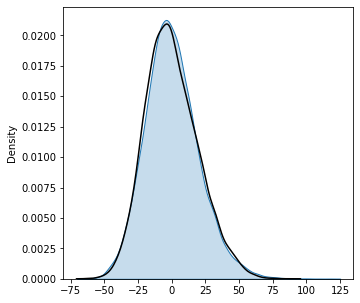

In [90]:
# Comparison of bootstrapped distributions from obs. and piControl models

f, ax = plt.subplots(1, figsize=(5.20, 5))
sns.kdeplot(piMB_btPerc_ar, fill=True, ax=ax, palette='gray')
sns.kdeplot(boot_data[reg].values.flatten(), fill=False, ax=ax, color='black')

plt.show()
plt.close()


In [91]:
# boot_data.columns

In [92]:
sy_all = 1900
ly_all = 2019

id_syear = 1959
id_myear = 2017
id_lyear = 2019

In [93]:
awapMB_cl.rolling(10,  center=True).mean()[awapMB_cl.index.year <= id_syear].std()

awap    2.783922
dtype: float64

In [94]:
def df_mean_sigma(df_tmp):
    piMeans = df_tmp.mean()
    piStd = df_tmp.std()
    pi_stat = pd.DataFrame({'mu':piMeans.values, 'sigma':piStd.values}, index=piMeans.index)
    
    return pi_stat

In [95]:
# Key stats for 1900 -1959 periods, for awap and for historical runs
awapMB_mu_std60 = df_mean_sigma(awapMB_cl[awapMB_cl.index.year <= id_syear])

comb585MB_mu_std60 = df_mean_sigma(dfMB_hist_ssp585_cl[dfMB_hist_ssp585_cl.index.year <= id_syear])
comb370MB_mu_std60 = df_mean_sigma(dfMB_hist_ssp370_cl[dfMB_hist_ssp370_cl.index.year <= id_syear])
comb245MB_mu_std60 = df_mean_sigma(dfMB_hist_ssp245_cl[dfMB_hist_ssp245_cl.index.year <= id_syear])
comb126MB_mu_std60 = df_mean_sigma(dfMB_hist_ssp126_cl[dfMB_hist_ssp126_cl.index.year <= id_syear])


# Key stats for recent 3Years (2017 -2019) period, for awap and for historical runs
awapMB_mu_std20 = df_mean_sigma(awapMB_cl[(awapMB_cl.index.year >= id_myear) &
                                                 (awapMB_cl.index.year <= id_lyear)])

comb585MB_mu_std20 = df_mean_sigma(dfMB_hist_ssp585_cl[(dfMB_hist_ssp585_cl.index.year >= id_myear) &
                                                 (dfMB_hist_ssp585_cl.index.year <= id_lyear)])

comb370MB_mu_std20 = df_mean_sigma(dfMB_hist_ssp370_cl[(dfMB_hist_ssp370_cl.index.year >= id_myear) &
                                                 (dfMB_hist_ssp370_cl.index.year <= id_lyear)])

comb245MB_mu_std20 = df_mean_sigma(dfMB_hist_ssp245_cl[(dfMB_hist_ssp245_cl.index.year >= id_myear) &
                                                 (dfMB_hist_ssp245_cl.index.year <= id_lyear)])

comb126MB_mu_std20 = df_mean_sigma(dfMB_hist_ssp126_cl[(dfMB_hist_ssp126_cl.index.year >= id_myear) &
                                                 (dfMB_hist_ssp126_cl.index.year <= id_lyear)])

In [96]:
MBVic_dic = {'awap_mu_std60':awapMB_mu_std60, 
             'comb585_mu_std60':comb585MB_mu_std60,
             'comb370_mu_std60':comb370MB_mu_std60,
             'comb245_mu_std60':comb245MB_mu_std60,
             'comb126_mu_std60':comb126MB_mu_std60,
             'awap_mu_std20':awapMB_mu_std20, 
             'comb585_mu_std20':comb585MB_mu_std20,
             'comb370_mu_std20':comb370MB_mu_std20,
             'comb245_mu_std20':comb245MB_mu_std20,
             'comb126_mu_std20':comb126MB_mu_std20}

In [97]:
MBVic_dic.keys()

dict_keys(['awap_mu_std60', 'comb585_mu_std60', 'comb370_mu_std60', 'comb245_mu_std60', 'comb126_mu_std60', 'awap_mu_std20', 'comb585_mu_std20', 'comb370_mu_std20', 'comb245_mu_std20', 'comb126_mu_std20'])

In [98]:
MBVic_dic['awap_mu_std60']

,mu,sigma
awap,31.588718,9.643563


In [99]:
import string
# import matplotlib 
# matplotlib.rc('xtick', labelsize=12) 
# matplotlib.rc('ytick', labelsize=12) 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [100]:
def get_perctage_of_models_with_same_sign(df_in, stat='median'):
    
    if stat == 'median':
        med_dat = df_in.median()
    
    num_same_sgn = df_in[np.sign(df_in) == np.sign(med_dat)].shape[0]
    
    num_models = df_in.shape[0]
    perc_same_sgn = 100 * num_same_sgn/num_models
    pr1 = np.round(perc_same_sgn/100, decimals=2)
    pr11 = int(pr1*100)
    
    return num_models, pr11
    
    

In [101]:
data_dic = MBVic_dic.copy()

In [102]:
reg = 'TBDreg'

In [103]:
# Climatology 

dfMB_hist_ssp585_cl_clim = dfMB_hist_ssp585_cl[(dfMB_hist_ssp585_cl.index.year>=1900) & \
                                               (dfMB_hist_ssp585_cl.index.year<=1959)].mean()

dfMB_hist_ssp370_cl_clim = dfMB_hist_ssp370_cl[(dfMB_hist_ssp370_cl.index.year>=1900) & \
                                               (dfMB_hist_ssp370_cl.index.year<=1959)].mean()

dfMB_hist_ssp245_cl_clim = dfMB_hist_ssp245_cl[(dfMB_hist_ssp245_cl.index.year>=1900) & \
                                               (dfMB_hist_ssp245_cl.index.year<=1959)].mean()

dfMB_hist_ssp126_cl_clim = dfMB_hist_ssp126_cl[(dfMB_hist_ssp126_cl.index.year>=1900) & \
                                               (dfMB_hist_ssp126_cl.index.year<=1959)].mean()

In [104]:
dfMB_hist_ssp585_cl_3y = dfMB_hist_ssp585_cl.rolling(3, center= True ).mean()
dfMB_hist_ssp370_cl_3y = dfMB_hist_ssp370_cl.rolling(3, center= True ).mean()
dfMB_hist_ssp245_cl_3y = dfMB_hist_ssp245_cl.rolling(3, center= True ).mean()
dfMB_hist_ssp126_cl_3y = dfMB_hist_ssp126_cl.rolling(3, center= True ).mean()

In [105]:
# dfMB_hist_ssp585_cl_3y

In [106]:
# Anomaly
dfMB_hist_ssp585_cl_3y_anom = dfMB_hist_ssp585_cl_3y - dfMB_hist_ssp585_cl_clim
dfMB_hist_ssp370_cl_3y_anom = dfMB_hist_ssp370_cl_3y - dfMB_hist_ssp370_cl_clim
dfMB_hist_ssp245_cl_3y_anom = dfMB_hist_ssp245_cl_3y - dfMB_hist_ssp245_cl_clim
dfMB_hist_ssp126_cl_3y_anom = dfMB_hist_ssp126_cl_3y - dfMB_hist_ssp126_cl_clim

In [108]:
# dfMB_hist_ssp585_cl_3y_anom

In [109]:
# % Change in 3-year mean rainfall
dfMB_hist_ssp585_cl_3y_perc = 100 * dfMB_hist_ssp585_cl_3y_anom / dfMB_hist_ssp585_cl_clim
dfMB_hist_ssp370_cl_3y_perc = 100 * dfMB_hist_ssp370_cl_3y_anom / dfMB_hist_ssp370_cl_clim
dfMB_hist_ssp245_cl_3y_perc = 100 * dfMB_hist_ssp245_cl_3y_anom / dfMB_hist_ssp245_cl_clim
dfMB_hist_ssp126_cl_3y_perc = 100 * dfMB_hist_ssp126_cl_3y_anom / dfMB_hist_ssp126_cl_clim

In [110]:
# dfMB_hist_ssp585_cl_3y_perc[(dfMB_hist_ssp585_cl_3y_perc.index.year==2018)].transpose()

In [111]:
# 100*(comb585_mu_std20.mu - comb585_mu_std60.mu)/comb585_mu_std60.mu.values

"""
1. In addition to the SSPs for 2017-2019, we could also pull out the rainfall anomalies for the driest 3 consecutive 
cool seasons during the decade surrounding the actual drought (ie. between 2014-2023). 
That would then be combining a dry period of natural variability with the representative anthropogenic component.
"""


In [112]:
rct_SPP585 = dfMB_hist_ssp585_cl_3y_perc[(dfMB_hist_ssp585_cl_3y_perc.index.year>=2014) & \
                                        (dfMB_hist_ssp585_cl_3y_perc.index.year<=2023)]#.values.flatten()

rct_SPP370 = dfMB_hist_ssp370_cl_3y_perc[(dfMB_hist_ssp370_cl_3y_perc.index.year>=2014) & \
                                        (dfMB_hist_ssp370_cl_3y_perc.index.year<=2023)]#.values.flatten()

rct_SPP245 = dfMB_hist_ssp245_cl_3y_perc[(dfMB_hist_ssp245_cl_3y_perc.index.year>=2014) & \
                                        (dfMB_hist_ssp245_cl_3y_perc.index.year<=2023)]#.values.flatten()

rct_SPP126 = dfMB_hist_ssp126_cl_3y_perc[(dfMB_hist_ssp126_cl_3y_perc.index.year>=2014) & \
                                        (dfMB_hist_ssp126_cl_3y_perc.index.year<=2023)]#.values.flatten()

In [113]:
# rct_SPP585

In [114]:
# rct_SPP585[rct_SPP585 > 0]

In [115]:
rct_SPP585.min().sort_values()

MPI-ESM1-2-LR      -53.539762
NorESM2-MM         -51.929807
MPI-ESM1-2-HR      -47.694619
CESM2-WACCM        -46.952531
ACCESS-CM2         -41.816886
CMCC-ESM2          -41.330445
AWI-CM-1-1-MR      -38.270122
EC-Earth3          -38.019475
EC-Earth3-Veg      -36.989889
CAS-ESM2-0         -36.673952
CMCC-CM2-SR5       -36.123434
TaiESM1            -35.733373
NorESM2-LM         -34.136395
GFDL-ESM4          -34.072388
FIO-ESM-2-0        -32.154014
GFDL-CM4           -31.388830
BCC-CSM2-MR        -30.159777
MRI-ESM2-0         -29.566990
INM-CM5-0          -27.292204
CIESM              -25.793603
FGOALS-g3          -23.962875
EC-Earth3-CC       -22.518449
IPSL-CM6A-LR       -16.921616
EC-Earth3-Veg-LR   -16.330134
ACCESS-ESM1-5      -15.734610
CanESM5            -15.664041
KACE-1-0-G         -13.315131
NESM3              -13.036465
INM-CM4-8          -11.487555
E3SM-1-1            -8.194552
MIROC6              -3.620349
CESM2               -1.146360
FGOALS-f3-L         11.683182
dtype: flo

In [116]:
# rct_SPP585['FGOALS-f3-L']

In [117]:
pd.concat([rct_SPP585.min(), rct_SPP370.min(), rct_SPP245.min(), rct_SPP126.min()], axis=1)

,0,1,2,3
ACCESS-CM2,-41.816886,-38.854361,-26.128346,-30.934924
ACCESS-ESM1-5,-15.734610,-47.288349,-28.908157,-27.083382
AWI-CM-1-1-MR,-38.270122,-24.357074,-40.301900,-30.263335
BCC-CSM2-MR,-30.159777,-11.103620,-18.382816,-8.748397
CanESM5,-15.664041,-20.888786,-30.742725,-33.200452
CAS-ESM2-0,-36.673952,-11.199672,-13.530787,-13.950629
CESM2-WACCM,-46.952531,-47.058717,-34.665557,-29.652745
CESM2,-1.146360,NaN,NaN,-13.324522
CIESM,-25.793603,NaN,-51.805043,-39.182202
CMCC-CM2-SR5,-36.123434,-18.448882,-35.607250,-41.334910


In [118]:
# Create a dataframe of driest 3-year during 2014-2023 period under all scenarios
df_rct_min = pd.DataFrame.from_dict({'SSP5.85':rct_SPP585.min().values.flatten(), 
                      'SSP3.70':rct_SPP370.min().values.flatten(),
                      'SSP2.45':rct_SPP245.min().values.flatten(),
                      'SSP1.26':rct_SPP126.min().values.flatten()}, orient='index').transpose()

In [119]:
df_rct_min

,SSP5.85,SSP3.70,SSP2.45,SSP1.26
0,-41.816886,-38.854361,-26.128346,-30.934924
1,-15.734610,-47.288349,-28.908157,-27.083382
2,-38.270122,-24.357074,-40.301900,-30.263335
3,-30.159777,-11.103620,-18.382816,-8.748397
4,-15.664041,-20.888786,-30.742725,-33.200452
5,-36.673952,-11.199672,-13.530787,-13.950629
6,-46.952531,-47.058717,-34.665557,-29.652745
7,-1.146360,-18.448882,-51.805043,-13.324522
8,-25.793603,-33.214091,-35.607250,-39.182202
9,-36.123434,-23.576020,-31.257177,-41.334910


In [120]:
df_rct_min_all = df_rct_min.values.flatten()
df_rct_min_all = df_rct_min_all[~np.isnan(df_rct_min_all)]



In [121]:
np.sort(df_rct_min_all)

array([-55.03650841, -54.45307289, -53.53976217, -51.92980729,
       -51.80504271, -50.71671778, -48.99578454, -48.05766696,
       -47.69461868, -47.37071969, -47.28834894, -47.05871719,
       -46.95253058, -45.26950222, -44.48047684, -44.0413442 ,
       -43.71428195, -42.8499779 , -42.52220445, -42.49009222,
       -41.81688642, -41.33491006, -41.33044535, -41.22423394,
       -40.75869669, -40.54249142, -40.30190043, -39.18220172,
       -38.85436104, -38.65024666, -38.27012231, -38.01947457,
       -36.98988852, -36.67395219, -36.51439493, -36.12343358,
       -35.73337326, -35.60724973, -35.5291132 , -35.52266008,
       -35.35709409, -34.66555701, -34.13639468, -34.07238826,
       -33.26232425, -33.2140907 , -33.20045193, -32.15401384,
       -31.80372549, -31.60368747, -31.38882957, -31.29121898,
       -31.25717676, -30.93492394, -30.74272458, -30.68192608,
       -30.47545115, -30.26333507, -30.15977665, -30.14857331,
       -30.03686973, -29.65274483, -29.56699006, -29.43

In [122]:
dry_pct = np.quantile(df_rct_min_all, q=[0, 0.25, 0.5, 0.75,1])

In [123]:
dry_pct

array([-55.03650841, -38.14479844, -29.65274483, -18.82039831,
        15.65928887])

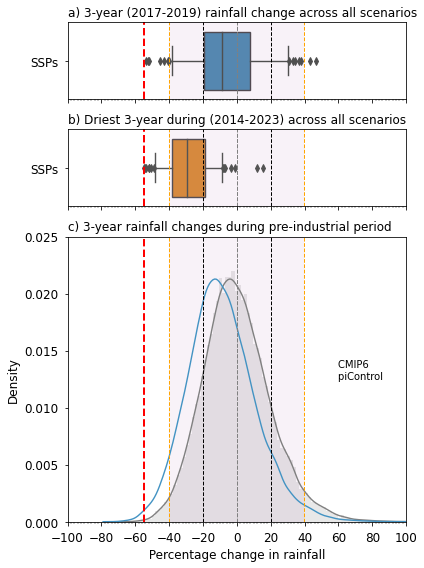

In [126]:
pi_boot_ar = piMB_btPerc_ar.copy()
pi_dis_std = np.std(pi_boot_ar)

awap_mu_std20 = data_dic['awap_mu_std20']
awap_mu_std60 = data_dic['awap_mu_std60']


comb585_mu_std20 = data_dic['comb585_mu_std20']
comb370_mu_std20 = data_dic['comb370_mu_std20']
comb245_mu_std20 = data_dic['comb245_mu_std20']
comb126_mu_std20 = data_dic['comb126_mu_std20']

comb585_mu_std60 = data_dic['comb585_mu_std60']
comb370_mu_std60 = data_dic['comb370_mu_std60']
comb245_mu_std60 = data_dic['comb245_mu_std60']
comb126_mu_std60 = data_dic['comb126_mu_std60']


obsDiff = 100*(awap_mu_std20.mu - awap_mu_std60.mu).values/awap_mu_std60.mu.values

mod585Diff = 100*(comb585_mu_std20.mu - comb585_mu_std60.mu)/comb585_mu_std60.mu.values
mod370Diff = 100*(comb370_mu_std20.mu - comb370_mu_std60.mu)/comb370_mu_std60.mu.values
mod245Diff = 100*(comb245_mu_std20.mu - comb245_mu_std60.mu)/comb245_mu_std60.mu.values
mod126Diff = 100*(comb126_mu_std20.mu - comb126_mu_std60.mu)/comb126_mu_std60.mu.values

# Create a dataframe of all the differences
df_Diff = pd.concat([mod585Diff, mod370Diff, mod245Diff, mod126Diff], axis=1)
df_Diff.columns = ['SSP5.85', 'SSP3.70', 'SSP2.45', 'SSP1.26']


df_Diff_all = pd.DataFrame(df_Diff.values.flatten(), columns=['SSPs']).dropna()
modDiff = mod585Diff.copy()

# Create a dictionary to compute the magnitude of external forcing's contribution
stat_table_perc = {}

stat_table_perc['obsDiff'] = obsDiff
stat_table_perc['mod585Diff'] = mod585Diff
stat_table_perc['mod370Diff'] = mod370Diff
stat_table_perc['mod245Diff'] = mod245Diff
stat_table_perc['mod126Diff'] = mod126Diff


xmin = -100
xmax = 100
nums = int((xmax-xmin)/0.5+1)
# nums = (xmax-xmin)+1
bins = np.linspace(xmin,xmax,num=nums)

wmin = 5
wmax = 95

c1 = "#980002"
c2 = "#df0000"
c3 = "#f69320"
c4 = "#4393C3" #"#003466"

with plt.style.context('seaborn-paper'):

    f, (ax_box, ax_box_dry, ax_hist) = plt.subplots(3, sharex=True, figsize=(6, 8),
                                        gridspec_kw={"height_ratios": (0.175, 0.175, 0.65)})

    ax_box.xaxis.set_tick_params(labelsize=12)
    ax_box.yaxis.set_tick_params(labelsize=12)
    
    sns.boxplot(data = df_Diff_all, orient='h', ax=ax_box, color=c4, whis=(wmin, wmax),
                width=0.75, saturation=0.75)
#     sns.boxplot(data = df_Diff, orient='h', ax=ax_box, color=None, palette=[c1, c2, c3, c4], whis=(wmin, wmax),
#                 width=0.75, saturation=0.75)
    ax_box.axvline(obsDiff, linewidth=2, color='r', linestyle='--')
#     ax_box.axvline(linewidth=2, color='k', linestyle='--')
    ax_box.axvline(linewidth=1, color='gray', linestyle='--')
#     ax_box.set_title('Cool (Apr-Sep) season', fontsize=14)
    ax_box.set_title('a) 3-year (2017-2019) rainfall change across all scenarios', fontsize=12, loc = 'left')
    ax_box.axvspan(-2*pi_dis_std, 2*pi_dis_std, alpha=0.05, color='purple')
    ax_box.axvline(0, linewidth=1, color='gray', linestyle='--')
    ax_box.axvline(pi_dis_std, linewidth=1, color='k', linestyle='--')
    ax_box.axvline(-1*pi_dis_std, linewidth=1, color='k', linestyle='--')
    ax_box.axvline(2*pi_dis_std, linewidth=1, color='orange', linestyle='--')
    ax_box.axvline(-2*pi_dis_std, linewidth=1, color='orange', linestyle='--')
    
    
    # Add % of models that have same sign as median
    
    df_Diff_all2 = df_Diff_all.dropna()
    len_all = df_Diff_all2.shape[0]
    df_Diff_sg_med = df_Diff_all2[np.sign(df_Diff_all2) == np.sign(df_Diff_all2.median()).values[0]].dropna()
    
    len_sg = df_Diff_sg_med.shape[0]
    propPerc_all = int(100 * len_sg / len_all)
    
#     ax_box.text(xmax-45.5, 0, "[{0}% of {1}]".format(str(propPerc_all), str(len_all)), fontsize=12)
    
#     len_ssp585, propPerc1 = get_perctage_of_models_with_same_sign(mod585Diff, stat = 'median')
#     len_ssp370, propPerc2 = get_perctage_of_models_with_same_sign(mod370Diff, stat = 'median')
#     len_ssp245, propPerc3 = get_perctage_of_models_with_same_sign(mod245Diff, stat = 'median')
#     len_ssp126, propPerc4 = get_perctage_of_models_with_same_sign(mod126Diff, stat = 'median')

#     ax_box.text(xmax-38.5, 0, "[{0} % of {1}]".format(str(propPerc1), str(len_ssp585)), fontsize=10)
#     ax_box.text(xmax-38.5, 1, "[{0} % of {1}]".format(str(propPerc2), str(len_ssp370)), fontsize=10)
#     ax_box.text(xmax-38.5, 2, "[{0} % of {1}]".format(str(propPerc3), str(len_ssp245)), fontsize=10)
#     ax_box.text(xmax-38.5, 3, "[{0} % of {1}]".format(str(propPerc4), str(len_ssp126)), fontsize=10)
    
    df_min3_all = pd.DataFrame(df_rct_min_all, columns=['SSPs'])
    
    ax_box_dry.xaxis.set_tick_params(labelsize=12)
    ax_box_dry.yaxis.set_tick_params(labelsize=12)
    
    sns.boxplot(data = df_min3_all, orient='h', ax=ax_box_dry, color=c3, whis=(wmin, wmax),
                width=0.75, saturation=0.75)
#     sns.boxplot(data = df_Diff, orient='h', ax=ax_box_dry, color=None, palette=[c1, c2, c3, c4], whis=(wmin, wmax),
#                 width=0.75, saturation=0.75)
    ax_box_dry.axvline(obsDiff, linewidth=2, color='r', linestyle='--')
#     ax_box_dry.axvline(linewidth=2, color='k', linestyle='--')
    ax_box_dry.axvline(linewidth=1, color='gray', linestyle='--')
#     ax_box_dry.set_title('Cool (Apr-Sep) season', fontsize=14)
    ax_box_dry.set_title('b) Driest 3-year during (2014-2023) across all scenarios', fontsize=12, loc = 'left')
    ax_box_dry.axvspan(-2*pi_dis_std, 2*pi_dis_std, alpha=0.05, color='purple')
    ax_box_dry.axvline(0, linewidth=1, color='gray', linestyle='--')
    ax_box_dry.axvline(pi_dis_std, linewidth=1, color='k', linestyle='--')
    ax_box_dry.axvline(-1*pi_dis_std, linewidth=1, color='k', linestyle='--')
    ax_box_dry.axvline(2*pi_dis_std, linewidth=1, color='orange', linestyle='--')
    ax_box_dry.axvline(-2*pi_dis_std, linewidth=1, color='orange', linestyle='--')
    

    # Plot piControl distribution
    
    ax_hist.xaxis.set_tick_params(labelsize=12)
    ax_hist.yaxis.set_tick_params(labelsize=12)

    sns.distplot(pi_boot_ar, bins=100, hist=True, norm_hist=True, ax=ax_hist, kde_kws={ "color": "gray"}, 
             hist_kws={"color": "lightgray", "alpha":0.5})
    
    sns.distplot(pi_boot_ar + df_Diff_all.median().values, bins=100, hist=False, norm_hist=True, ax=ax_hist, 
                 kde_kws={ "color": c4, "linestyle":'-'})     
    ax_hist.axvline(linewidth=1, color='gray', linestyle='--')
    ax_hist.axvline(obsDiff, linewidth=2, color='r', linestyle='--')
#     ax_hist.text(0.80, 0.80,"{0} ".format(reg), fontsize=10, transform=ax_hist.transAxes)
    ax_hist.text(0.80, 0.50,"CMIP6 \npiControl ", fontsize=10, transform=ax_hist.transAxes)

    ax_hist.axvspan(-2*pi_dis_std, 2*pi_dis_std, alpha=0.05, color='purple')
    ax_hist.axvline(0, linewidth=1, color='gray', linestyle='--')
    ax_hist.axvline(pi_dis_std, linewidth=1, color='k', linestyle='--')
    ax_hist.axvline(-1*pi_dis_std, linewidth=1, color='k', linestyle='--')
    ax_hist.axvline(2*pi_dis_std, linewidth=1, color='orange', linestyle='--')
    ax_hist.axvline(-2*pi_dis_std, linewidth=1, color='orange', linestyle='--')
#     ax_hist.set_xlabel('100*('+r'$\bar {X}_{2017-2019} - \mu_{1900-1959})/ \mu_{1900-1959}$',
#                        fontsize=12)
    ax_hist.set_xlabel(' Percentage change in rainfall ', fontsize=12)
#     ax_hist.xaxis.set_minor_locator(plt.MultipleLocator())
    ax_hist.xaxis.set_major_locator(plt.MultipleLocator(20))
    ax_hist.xaxis.set_minor_locator(plt.MultipleLocator(2))
    
    ax_hist.set_ylim(0, 0.025)

    ax_hist.set_ylabel("Density", fontsize=12)
    ax_hist.set_title('c) 3-year rainfall changes during pre-industrial period', fontsize=12, loc = 'left')
    plt.xlim(xmin, xmax)
    plt.tight_layout()
    

#     save_png = 'Fig09_V2_ContExtForcing_TinderBox_Drought_and_driest3year.pdf'
#     fname_sav = os.path.join(pltDir, save_png)
#     plt.savefig(fname_sav, dpi=300, bbox_inches='tight', orientation='portrait')

    
    plt.show()
    plt.close()

In [127]:
# fname_sav

In [128]:
Hlen = len(stat_table_perc['mod585Diff'])
M1len = len(stat_table_perc['mod370Diff'])
M2len = len(stat_table_perc['mod245Diff'])
Llen = len(stat_table_perc['mod126Diff'])

In [129]:
print(Hlen, M1len, M2len, Llen)

33 28 31 31


In [130]:
Tlen = Hlen + M1len + M2len + Llen

In [131]:
Tlen

123

In [132]:
Hlen_wt, M1len_wt, M2len_wt, Llen_wt = Hlen/Tlen, M1len/Tlen, M2len/Tlen, Llen/Tlen

In [133]:
print(Hlen_wt, M1len_wt, M2len_wt, Llen_wt)

0.2682926829268293 0.22764227642276422 0.25203252032520324 0.25203252032520324


In [134]:
obs_ch = stat_table_perc['obsDiff']
Q1H, Q2H, Q3H = np.quantile(stat_table_perc['mod585Diff'], q = [0.25, 0.5, 0.75])
Q1M1, Q2M1, Q3M1 = np.quantile(stat_table_perc['mod370Diff'], q = [0.25, 0.5, 0.75])
Q1M2, Q2M2, Q3M2 = np.quantile(stat_table_perc['mod245Diff'], q = [0.25, 0.5, 0.75])
Q1L, Q2L, Q3L = np.quantile(stat_table_perc['mod126Diff'], q = [0.25, 0.5, 0.75])

# Compute the weithed mean
Q1_wt = Hlen_wt*Q1H + M1len_wt*Q1M1 + M2len_wt*Q1M2 + Llen_wt*Q1L
Q2_wt = Hlen_wt*Q2H + M1len_wt*Q2M1 + M2len_wt*Q2M2 + Llen_wt*Q2L
Q3_wt = Hlen_wt*Q3H + M1len_wt*Q3M1 + M2len_wt*Q3M2 + Llen_wt*Q3L

# Comute the % contribution from external forcing
CQ1 = 100*Q1_wt/obs_ch[0]
CQ2 = 100*Q2_wt/obs_ch[0]
CQ3 = 100*Q3_wt/obs_ch[0]

print("------------------------------------------------------------ ----------------")

print("------")
print(" Observed Change = {0:0.2f}%".format(obs_ch[0]))
print(" The change for SSP5-8.5 at Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(Q2H, Q1H, Q3H))
print(" The change for SSP3-7.0 at Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(Q2M1, Q1M1, Q3M1))
print(" The change for SSP2-4.5 at Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(Q2M2, Q1M2, Q3M2))
print(" The change for SSP1-2.6 at Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(Q2L, Q1L, Q3L))

print(" The weighted mean at Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(Q2_wt, Q1_wt, Q3_wt))

print(" The relative contribution using Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(CQ2, CQ1, CQ3))
print("------------------------------------------------------------ ----------------")

------------------------------------------------------------ ----------------
------
 Observed Change = -54.67%
 The change for SSP5-8.5 at Q2, (Q1 and Q3) are = -8.43% (-16.53%, 7.66%)
 The change for SSP3-7.0 at Q2, (Q1 and Q3) are = -15.96% (-19.43%, 8.11%)
 The change for SSP2-4.5 at Q2, (Q1 and Q3) are = -7.98% (-16.80%, 3.50%)
 The change for SSP1-2.6 at Q2, (Q1 and Q3) are = -8.53% (-23.70%, 9.72%)
 The weighted mean at Q2, (Q1 and Q3) are = -10.05% (-19.06%, 7.23%)
 The relative contribution using Q2, (Q1 and Q3) are = 18.39% (34.87%, -13.23%)
------------------------------------------------------------ ----------------


In [136]:
# Shifting IVAR distribution left using the anthropogenic contribution

In [137]:
print("Probability (%) due to adjusted internal variability")
print("Probability of rainfall change equal to or less than \nthe modelled internal variability over drought region")
print("**********************")

probInt_perR_MB_adj = 100*sum(piMB_btPerc_ar + Q2_wt <= perR_MB)/len(piMB_btPerc_ar)
print("Using perR = {0:.2f}%".format(probInt_perR_MB_adj))
print("**********")


Probability (%) due to adjusted internal variability
Probability of rainfall change equal to or less than 
the modelled internal variability over drought region
**********************
Using perR = 0.59%
**********


In [138]:
obs_diff

-54.66578647691411

In [139]:
df_Diff_all[df_Diff_all<-50].count()

SSPs    3
dtype: int64

In [140]:
df_rct_min_all[df_rct_min_all <= np.quantile(df_rct_min_all, q=0.05)]

array([-51.80504271, -55.03650841, -50.71671778, -48.99578454,
       -54.45307289, -53.53976217, -51.92980729])

In [141]:
perR_sim_25 = df_Diff_all.quantile(q=0.25).values
perR_sim_50 = df_Diff_all.quantile(q=0.50).values
perR_sim_75 = df_Diff_all.quantile(q=0.75).values

In [142]:
print(perR_sim_25, perR_sim_50, perR_sim_75)

[-19.29269555] [-8.76407385] [7.48198339]


In [143]:
print("***SHIFTING IVAR DISTRIBUTION *******")
probInt_perR25_MB_1 = 100*sum(piMB_btPerc_ar-np.abs(perR_sim_25) <= perR_MB)/len(piMB_btPerc_ar)
print("Using perR and after adjusting IVAR dist for 25th percentile= {0:.3f}%".format(probInt_perR25_MB_1))
print("**********")

***SHIFTING IVAR DISTRIBUTION *******
Using perR and after adjusting IVAR dist for 25th percentile= 2.581%
**********


In [144]:
print("***SHIFTING IVAR DISTRIBUTION (This value is used in the paper) *******")
probInt_perR50_MB_1 = 100*sum(piMB_btPerc_ar-np.abs(perR_sim_50) <= perR_MB)/len(piMB_btPerc_ar)
print("Using perR and after adjusting IVAR dist for 50th percentile= {0:.3f}%".format(probInt_perR50_MB_1))


print("**********")

***SHIFTING IVAR DISTRIBUTION (This value is used in the paper) *******
Using perR and after adjusting IVAR dist for 50th percentile= 0.452%
**********


In [145]:
print("***SHIFTING IVAR DISTRIBUTION*******")
probInt_perR75_MB_1 = 100*sum(piMB_btPerc_ar-np.abs(perR_sim_75) <= perR_MB)/len(piMB_btPerc_ar)
print("Using perR and after adjusting IVAR dist for 75th percentile= {0:.3f}%".format(probInt_perR75_MB_1))
print("**********")

***SHIFTING IVAR DISTRIBUTION*******
Using perR and after adjusting IVAR dist for 75th percentile= 0.323%
**********


In [146]:
100*sum(piMB_btPerc_ar <= perR_MB)/len(piMB_btPerc_ar)

0.054838709677419356

In [147]:
0.448/0.055

8.145454545454546

In [148]:
# Estimate the FAR and RR

In [149]:
cen_sy = 2009
cen_ly = 2028

In [150]:
cen_SPP585 = dfMB_hist_ssp585_cl_3y_perc[(dfMB_hist_ssp585_cl_3y_perc.index.year>=cen_sy) & \
                                        (dfMB_hist_ssp585_cl_3y_perc.index.year<=cen_ly)]#.values.flatten()

cen_SPP370 = dfMB_hist_ssp370_cl_3y_perc[(dfMB_hist_ssp370_cl_3y_perc.index.year>=cen_sy) & \
                                        (dfMB_hist_ssp370_cl_3y_perc.index.year<=cen_ly)]#.values.flatten()

cen_SPP245 = dfMB_hist_ssp245_cl_3y_perc[(dfMB_hist_ssp245_cl_3y_perc.index.year>=cen_sy) & \
                                        (dfMB_hist_ssp245_cl_3y_perc.index.year<=cen_ly)]#.values.flatten()

cen_SPP126 = dfMB_hist_ssp126_cl_3y_perc[(dfMB_hist_ssp126_cl_3y_perc.index.year>=cen_sy) & \
                                        (dfMB_hist_ssp126_cl_3y_perc.index.year<=cen_ly)]#.values.flatten()

In [151]:
df_cen = pd.DataFrame.from_dict({'SSP5.85':cen_SPP585.values.flatten(), 
                      'SSP3.70':cen_SPP370.values.flatten(),
                      'SSP2.45':cen_SPP245.values.flatten(),
                      'SSP1.26':cen_SPP126.values.flatten()}, orient='index').transpose()

In [152]:
Pnat = 100*sum(piMB_btPerc_ar <= perR_MB)/len(piMB_btPerc_ar)
# print(Pnat)

n_exceed_all = []
n_len_all = []



print("Number of samples that are as dry or drier than the Tinderbox Drought")
print("in {0:4d}-{1:4d} period are as follows".format(cen_sy, cen_ly))
print("---------------------------")

for ssp in df_cen.columns:
    tmp = df_cen[ssp]
    
    n_exceed = tmp[tmp <= obsDiff[0]].dropna(how='all').count()
    
    n_exceed_all.append(n_exceed)
    
    n_len = len(tmp.dropna())
    n_len_all.append(n_len)
    
    p_exceed = 100 * n_exceed / n_len
    
    RR_ssp = p_exceed / Pnat
    
    
    
    print("For {0} scenario, {1:2d} out of {2:4d} samples (i.e., 20 years X {3:2d} models)".format(ssp, 
                                                                                n_exceed, n_len, int(n_len/20)))
    print("Giving rise to likelihood = {0:.3f} with RR = {1:.3f}".format(p_exceed, RR_ssp))
    print("---------------------------")
    
print("-----------****************************----------------")
print("Using all scenarios together, there are {0:3d} out of {1:5d} samples".format(np.sum(n_exceed_all), np.sum(n_len_all)))
Pall = 100 * np.sum(n_exceed_all) / np.sum(n_len_all)
# print(Pall)    
FAR = 1 - Pnat/Pall
RR = Pall / Pnat

print("Pall = {0:.2f}, Pnat = {1:.2f}, FAR = {2:.2f}, and RR = {3:.2f}".format(Pall, Pnat, FAR, RR))
print("---------------------------")

Number of samples that are as dry or drier than the Tinderbox Drought
in 2009-2028 period are as follows
---------------------------
For SSP5.85 scenario,  2 out of  660 samples (i.e., 20 years X 33 models)
Giving rise to likelihood = 0.303 with RR = 5.526
---------------------------
For SSP3.70 scenario,  2 out of  560 samples (i.e., 20 years X 28 models)
Giving rise to likelihood = 0.357 with RR = 6.513
---------------------------
For SSP2.45 scenario,  3 out of  620 samples (i.e., 20 years X 31 models)
Giving rise to likelihood = 0.484 with RR = 8.824
---------------------------
For SSP1.26 scenario,  2 out of  620 samples (i.e., 20 years X 31 models)
Giving rise to likelihood = 0.323 with RR = 5.882
---------------------------
-----------****************************----------------
Using all scenarios together, there are   9 out of  2460 samples
Pall = 0.37, Pnat = 0.05, FAR = 0.85, and RR = 6.67
---------------------------


In [153]:
tmp.shape

(660,)

In [154]:
np.sum(n_exceed_all)

9

In [155]:
n_len_all

[660, 560, 620, 620]

In [156]:
np.sum(n_len_all)

2460

In [157]:
100 * np.sum(n_exceed_all) / np.sum(n_len_all)

0.36585365853658536

In [158]:
len(tmp)

660

In [159]:
Pnat = 100*sum(piMB_btPerc_ar <= perR_MB)/len(piMB_btPerc_ar)
print(Pnat)

0.054838709677419356


In [160]:
Pall = 100 * np.sum(n_exceed_all) / np.sum(n_len_all)
print(Pall)

0.36585365853658536


In [161]:
FAR = 1 - Pnat/Pall
RR = Pall / Pnat

print("FAR = {0:.3f}, and RR = {1:.3f}".format(FAR, RR))

FAR = 0.850, and RR = 6.671


In [162]:
FAR

0.8501075268817204

In [163]:
df_cen[df_cen <= obsDiff[0]].dropna(how='all').dropna(axis=1, how='all').count().sum()

9

In [164]:
df_cen.count().sum()

2460

In [165]:
2460/20

123.0

In [166]:
100*df_cen[df_cen <= obsDiff[0]].dropna(how='all').dropna(axis=1, how='all').count().sum()/df_cen.count().sum()

0.36585365853658536

In [167]:


# This is all

In [110]:
Hlen = len(stat_table_perc['mod585Diff'])
M1len = len(stat_table_perc['mod370Diff'])
M2len = len(stat_table_perc['mod245Diff'])
Llen = len(stat_table_perc['mod126Diff'])

In [111]:
print(Hlen, M1len, M2len, Llen)

33 28 31 31


In [112]:
Tlen = Hlen + M1len + M2len + Llen

In [113]:
Tlen

123

In [114]:
Hlen_wt, M1len_wt, M2len_wt, Llen_wt = Hlen/Tlen, M1len/Tlen, M2len/Tlen, Llen/Tlen

In [115]:
print(Hlen_wt, M1len_wt, M2len_wt, Llen_wt)

0.2682926829268293 0.22764227642276422 0.25203252032520324 0.25203252032520324


In [116]:
obs_ch = stat_table_perc['obsDiff']
Q1H, Q2H, Q3H = np.quantile(stat_table_perc['mod585Diff'], q = [0.25, 0.5, 0.75])
Q1M1, Q2M1, Q3M1 = np.quantile(stat_table_perc['mod370Diff'], q = [0.25, 0.5, 0.75])
Q1M2, Q2M2, Q3M2 = np.quantile(stat_table_perc['mod245Diff'], q = [0.25, 0.5, 0.75])
Q1L, Q2L, Q3L = np.quantile(stat_table_perc['mod126Diff'], q = [0.25, 0.5, 0.75])

# Compute the weithed mean
Q1_wt = Hlen_wt*Q1H + M1len_wt*Q1M1 + M2len_wt*Q1M2 + Llen_wt*Q1L
Q2_wt = Hlen_wt*Q2H + M1len_wt*Q2M1 + M2len_wt*Q2M2 + Llen_wt*Q2L
Q3_wt = Hlen_wt*Q3H + M1len_wt*Q3M1 + M2len_wt*Q3M2 + Llen_wt*Q3L

# Comute the % contribution from external forcing
CQ1 = 100*Q1_wt/obs_ch[0]
CQ2 = 100*Q2_wt/obs_ch[0]
CQ3 = 100*Q3_wt/obs_ch[0]

print("------------------------------------------------------------ ----------------")

print("------")
print(" Observed Change = {0:0.2f}%".format(obs_ch[0]))
print(" The change for SSP5-8.5 at Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(Q2H, Q1H, Q3H))
print(" The change for SSP3-7.0 at Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(Q2M1, Q1M1, Q3M1))
print(" The change for SSP2-4.5 at Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(Q2M2, Q1M2, Q3M2))
print(" The change for SSP1-2.6 at Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(Q2L, Q1L, Q3L))

print(" The weighted mean at Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(Q2_wt, Q1_wt, Q3_wt))

print(" The relative contribution using Q2, (Q1 and Q3) are = {0:0.2f}% ({1:0.2f}%, {2:0.2f}%)".format(CQ2, CQ1, CQ3))
print("------------------------------------------------------------ ----------------")

------------------------------------------------------------ ----------------
------
 Observed Change = -54.67%
 The change for SSP5-8.5 at Q2, (Q1 and Q3) are = -8.43% (-16.53%, 7.66%)
 The change for SSP3-7.0 at Q2, (Q1 and Q3) are = -15.96% (-19.43%, 8.11%)
 The change for SSP2-4.5 at Q2, (Q1 and Q3) are = -7.98% (-16.80%, 3.50%)
 The change for SSP1-2.6 at Q2, (Q1 and Q3) are = -8.53% (-23.70%, 9.72%)
 The weighted mean at Q2, (Q1 and Q3) are = -10.05% (-19.06%, 7.23%)
 The relative contribution using Q2, (Q1 and Q3) are = 18.39% (34.87%, -13.23%)
------------------------------------------------------------ ----------------


In [117]:
print("Probability (%) due to adjusted internal variability")
print("Probability of rainfall change equal to or less than \nthe modelled internal variability over drought region")
print("**********************")

probInt_perR_MB_adj = 100*sum(piMB_btPerc_ar + Q2_wt <= perR_MB)/len(piMB_btPerc_ar)
print("Using perR = {0:.2f}%".format(probInt_perR_MB_adj))
print("**********")


Probability (%) due to adjusted internal variability
Probability of rainfall change equal to or less than 
the modelled internal variability over drought region
**********************
Using perR = 0.59%
**********


In [118]:
stat_table_perc['mod585Diff'].sort_values()[0:4]

MPI-ESM1-2-LR   -53.539762
MPI-ESM1-2-HR   -43.155424
CAS-ESM2-0      -27.482154
TaiESM1         -25.629746
Name: mu, dtype: float64

In [119]:
stat_table_perc['mod370Diff'].sort_values()[0:4]

IPSL-CM5A2-INCA   -32.915952
ACCESS-ESM1-5     -29.672163
INM-CM5-0         -29.437140
CanESM5           -20.888786
Name: mu, dtype: float64

In [120]:
stat_table_perc['mod245Diff'].sort_values()[0:4]

CIESM              -51.805043
AWI-CM-1-1-MR      -40.301900
EC-Earth3-Veg      -38.204313
EC-Earth3-Veg-LR   -26.644514
Name: mu, dtype: float64

In [121]:
stat_table_perc['mod126Diff'].sort_values()[0:4]

MPI-ESM1-2-LR   -52.641040
CMCC-ESM2       -45.269502
NorESM2-LM      -40.758697
FIO-ESM-2-0     -36.514395
Name: mu, dtype: float64

In [122]:
print("Probability (%) due to adjusted internal variability")
print("Probability of rainfall change equal to or less than \nthe modelled internal variability over drought regionm")
print("**********************")

probX_perR_MB_adj = 100*sum(awapMB_btPerc.values.flatten()+ Q2_wt <= perR_MB)/len(awapMB_btDiff.values)
print("Using perR = {0:.2f}%".format(probX_perR_MB_adj))
print("**********")


Probability (%) due to adjusted internal variability
Probability of rainfall change equal to or less than 
the modelled internal variability over drought regionm
**********************
Using perR = 0.39%
**********


In [123]:
probInt_perR_MB

0.054838709677419356

In [124]:
probX_perR_MB_adj / prob_perR_MB

19.5

In [125]:
probX_perR_MB_adj / probInt_perR_MB

7.111764705882353

In [126]:
RR = probInt_perR_MB_adj / probInt_perR_MB
print(RR)

10.76470588235294
